In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class WaveFunctionNN(nn.Module):
    def __init__(self, layers):
        super(WaveFunctionNN, self).__init__()
        self.layers=nn.ModuleList()

        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.acivation = nn.Tanh()
    
    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.acivation(self.layers[i](x))
        x = self.layers[-1](x)
        return x 

In [4]:
L = 5.0 
N_points = 200
x_collocation = np.linspace(-L, L, N_points)[:, None]
x_collocation = torch.tensor(x_collocation, dtype=torch.float32).to(device)

In [5]:
# Instantiate the model and move it to the device.
model = WaveFunctionNN(layers=[1, 50, 50, 1]).to(device)
# Treat the energy as a trainable parameter, and move it to the device.
E = torch.nn.Parameter(torch.tensor([0.5], dtype=torch.float32, device=device))

In [6]:
def loss_fn(x):
    # Ensure gradients are tracked on x.
    x.requires_grad_(True)
    psi = model(x)
    
    # Compute the first derivative dψ/dx.
    grad_psi = torch.autograd.grad(
        psi, x,
        grad_outputs=torch.ones_like(psi),
        create_graph=True
    )[0]
    
    # Compute the second derivative d²ψ/dx².
    grad2_psi = torch.autograd.grad(
        grad_psi, x,
        grad_outputs=torch.ones_like(grad_psi),
        create_graph=True
    )[0]
    
    # Hamiltonian for the harmonic oscillator in natural units:
    # H = -1/2 * d²/dx² + 1/2 * x².
    # The residual is: Hψ - Eψ = 0.
    residual = -0.5 * grad2_psi + 0.5 * (x**2) * psi - E * psi
    loss_residual = torch.mean(residual**2)
    
    # Enforce boundary conditions at x = -L and x = L (ψ should tend toward 0).
    psi_left = model(torch.tensor([[-L]], dtype=torch.float32, device=device))
    psi_right = model(torch.tensor([[L]], dtype=torch.float32, device=device))
    loss_boundary = torch.mean(psi_left**2 + psi_right**2)
    
    return loss_residual + loss_boundary

In [7]:
optimizer = optim.Adam(list(model.parameters()) + [E], lr=1e-3)

In [8]:
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(x_collocation)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Estimated Energy = {E.item():.6f}")

/home/gosh/anaconda3/envs/torch25/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1728945379270/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Loss = 0.139478, Estimated Energy = 0.501000
Epoch 1000: Loss = 0.000008, Estimated Energy = 0.505113
Epoch 2000: Loss = 0.000001, Estimated Energy = 0.507738
Epoch 3000: Loss = 0.000000, Estimated Energy = 0.506222
Epoch 4000: Loss = 0.000000, Estimated Energy = 0.511945
Epoch 5000: Loss = 0.000000, Estimated Energy = 0.506839
Epoch 6000: Loss = 0.000001, Estimated Energy = 0.529218
Epoch 7000: Loss = 0.000934, Estimated Energy = 0.519978
Epoch 8000: Loss = 0.000000, Estimated Energy = 0.505884
Epoch 9000: Loss = 0.000000, Estimated Energy = 0.508779


In [9]:

print("Training complete.")
print(f"Final estimated energy: {E.item():.6f}")

Training complete.
Final estimated energy: 0.516813


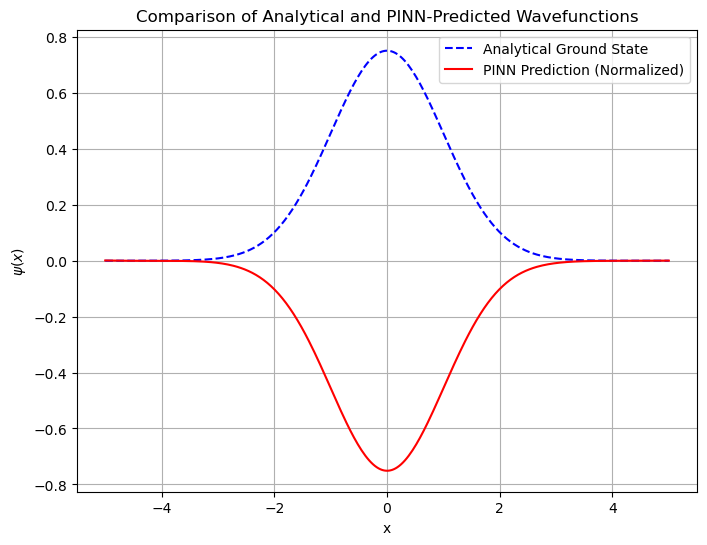

In [ ]:
# ------------------------------------------------------------------------------
# Plotting: Compare the network-predicted wavefunction to the analytical ground state.
# Analytical ground state for the 1D harmonic oscillator:
# ψ₀(x) = (1/π)^(1/4) * exp(-x²/2)
def psi_true(x):
    return (1/np.pi)**0.25 * np.exp(-x**2/2)

# Create a plotting domain.
x_plot = np.linspace(-L, L, 300)[:, None]
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32).to(device)

# Evaluate the trained model.
model.eval()
with torch.no_grad():
    psi_pred = model(x_plot_tensor).cpu().numpy()

# Compute the analytical solution.
psi_analytic = psi_true(x_plot)

# Optionally, normalize the predicted wavefunction.
norm_factor = np.sqrt(np.trapezoid(psi_pred[:, 0]**2, x_plot[:, 0]))
psi_pred_norm = psi_pred[:, 0] / norm_factor

# Plot the analytical and PINN-predicted wavefunctions.
plt.figure(figsize=(8, 6))
plt.plot(x_plot, psi_analytic, label='Analytical Ground State', linestyle='--', color='blue')
plt.plot(x_plot, psi_pred_norm, label='PINN Prediction (Normalized)', linestyle='-', color='red')
plt.xlabel('x')
plt.ylabel(r'$\psi(x)$')
plt.title('Comparison of Analytical and PINN-Predicted Wavefunctions')
plt.legend()
plt.grid(True)
plt.show()